In [ ]:
# conda install -c conda-forge eli5

In [126]:
import pandas as pd
from sklearn.model_selection import train_test_split

from lightgbm import LGBMRegressor
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
import shap
import eli5
from eli5.sklearn import PermutationImportance

from imblearn.over_sampling import SMOTE

from matplotlib import pyplot as plt
%matplotlib inline

import warnings
import gc
warnings.filterwarnings("ignore")

'''
Data Set
Clinical_Variable.csv
개인의 임상 정보를 담은 테이블. 10개의 임상변수가 존재하며
개인의 임상정보는 0~9까지의 수치로 대체한다.

Genetic_alterations.csv
유전자의 변형이 일어났는지를 표시한 테이블.
G1~G300의 column이 존재하며 변형이 일어나지 않았으면 0, 변형이 일어났으면 1로 표현한다. 

Survival_time_event.csv
생존기간과 사망여부를 표시한 테이블
time, event의 column이 존재하며
event가 1일경우 time은 사망시 생존기간을 의미하며
event가 0일경우 time은 현재까지의 생존기간을 의미한다.

Treatment.csv
하나뿐인 치료를 하였는지(1) 하지 아니하였는지(0)를 기록한 테이블
'''

In [127]:
clinic = pd.read_csv('datasets/Clinical_Variables.csv')
genetic = pd.read_csv('datasets/Genetic_alterations.csv')
survival = pd.read_csv('datasets/Survival_time_event.csv')
treatment = pd.read_csv('datasets/Treatment.csv')

clinic = clinic.drop('Unnamed: 0', axis=1)
genetic = genetic.drop('Unnamed: 0', axis=1)
survival = survival.drop('Unnamed: 0', axis=1)
treatment = treatment.drop('Unnamed: 0', axis=1)

df = pd.concat([clinic, genetic, treatment, survival], axis=1)
df_X = df.iloc[:,:-1]
df_y = df.iloc[:,-1]

In [128]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=42)

In [129]:

def modeling(model,x_train,x_test,y_train,y_test):
    model.fit(x_train,y_train)
    pred = model.predict(x_test)
    metrics(y_test,pred)
    
def metrics(y_test,pred):
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    roc_score_mac = roc_auc_score(y_test,pred,average='macro')
    roc_score_mic = roc_auc_score(y_test,pred,average='micro')
    print('정확도 : {0:.2f}, 정밀도 : {1:.2f}, 재현율 : {2:.2f}'.format(accuracy,precision,recall))
    print('f1-score : {0:.2f}, auc_mac : {1:.2f}, auc_mic : {2:.2f}'.format(f1,roc_score_mac,roc_score_mic))

In [130]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
modeling(lr,X_train,X_test,y_train,y_test)

정확도 : 0.84, 정밀도 : 0.89, 재현율 : 0.93
f1-score : 0.91, auc_mac : 0.58, auc_mic : 0.58


In [132]:
lgb_c = lgb.LGBMClassifier(n_estimators=1000,num_leaves=64,n_jobs=-1,boost_from_average=False)
modeling(lgb_c,X_train,X_test,y_train,y_test)

정확도 : 0.88, 정밀도 : 0.88, 재현율 : 0.99
f1-score : 0.93, auc_mac : 0.54, auc_mic : 0.54


In [133]:
# is_unbalance_=True
lgb_c = lgb.LGBMClassifier(n_estimators=1000,num_leaves=64,n_jobs=-1,
                     is_unbalance = True,boost_from_average=False)
modeling(lgb_c,X_train,X_test,y_train,y_test)

정확도 : 0.88, 정밀도 : 0.88, 재현율 : 0.99
f1-score : 0.94, auc_mac : 0.55, auc_mic : 0.55


In [71]:
smote = SMOTE(random_state=0)
X_train_over,y_train_over = smote.fit_sample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (800, 312) (800,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (1434, 312) (1434,)
SMOTE 적용 후 레이블 값 분포: 
 1    717
0    717
Name: event, dtype: int64


In [134]:
lr = LogisticRegression()
modeling(lr,X_train_over,X_test,y_train_over,y_test)

정확도 : 0.81, 정밀도 : 0.87, 재현율 : 0.91
f1-score : 0.89, auc_mac : 0.51, auc_mic : 0.51


In [135]:
lgb_c = lgb.LGBMClassifier(n_estimators=1000,num_leaves=64,n_jobs=-1,boost_from_average=False)
modeling(lgb_c,X_train_over,X_test,y_train_over,y_test)

정확도 : 0.88, 정밀도 : 0.88, 재현율 : 0.99
f1-score : 0.93, auc_mac : 0.54, auc_mic : 0.54


In [80]:
from BorutaShap import BorutaShap, load_data
from xgboost import XGBClassifier

In [85]:
Feature_Selector = BorutaShap(importance_measure='shap', classification=True)

Feature_Selector.fit(X=X_train, y=y_train, n_trials=50, random_state=0)


1 attributes confirmed important: ['time']
311 attributes confirmed unimportant: ['G79', 'G260', 'G32', 'G203', 'G49', 'Var9', 'G155', 'G188', 'G64', 'G238', 'G93', 'Var10', 'G282', 'G236', 'G107', 'G48', 'G217', 'Var3', 'G111', 'G113', 'G239', 'G264', 'G130', 'G270', 'G34', 'G226', 'G83', 'G192', 'G126', 'G39', 'G8', 'G257', 'G3', 'G30', 'G143', 'G224', 'G293', 'G253', 'G56', 'G31', 'G66', 'G275', 'G241', 'G85', 'G98', 'G142', 'Var5', 'G245', 'G112', 'G54', 'G157', 'G233', 'G82', 'G135', 'G23', 'G194', 'G179', 'G201', 'G152', 'G237', 'G140', 'G243', 'G124', 'G11', 'G86', 'G169', 'G294', 'G210', 'G182', 'G146', 'G43', 'G300', 'G80', 'G35', 'G230', 'G58', 'G191', 'G108', 'G174', 'G47', 'G131', 'G144', 'G63', 'G17', 'G221', 'G105', 'G227', 'G15', 'G145', 'G2', 'G65', 'G262', 'G123', 'G249', 'G46', 'G223', 'G288', 'G193', 'G125', 'Var8', 'G248', 'G295', 'G62', 'G269', 'G219', 'G202', 'G218', 'G235', 'G252', 'G104', 'G33', 'G158', 'G296', 'G59', 'G73', 'G114', 'G55', 'G89', 'Var6', 'G84',

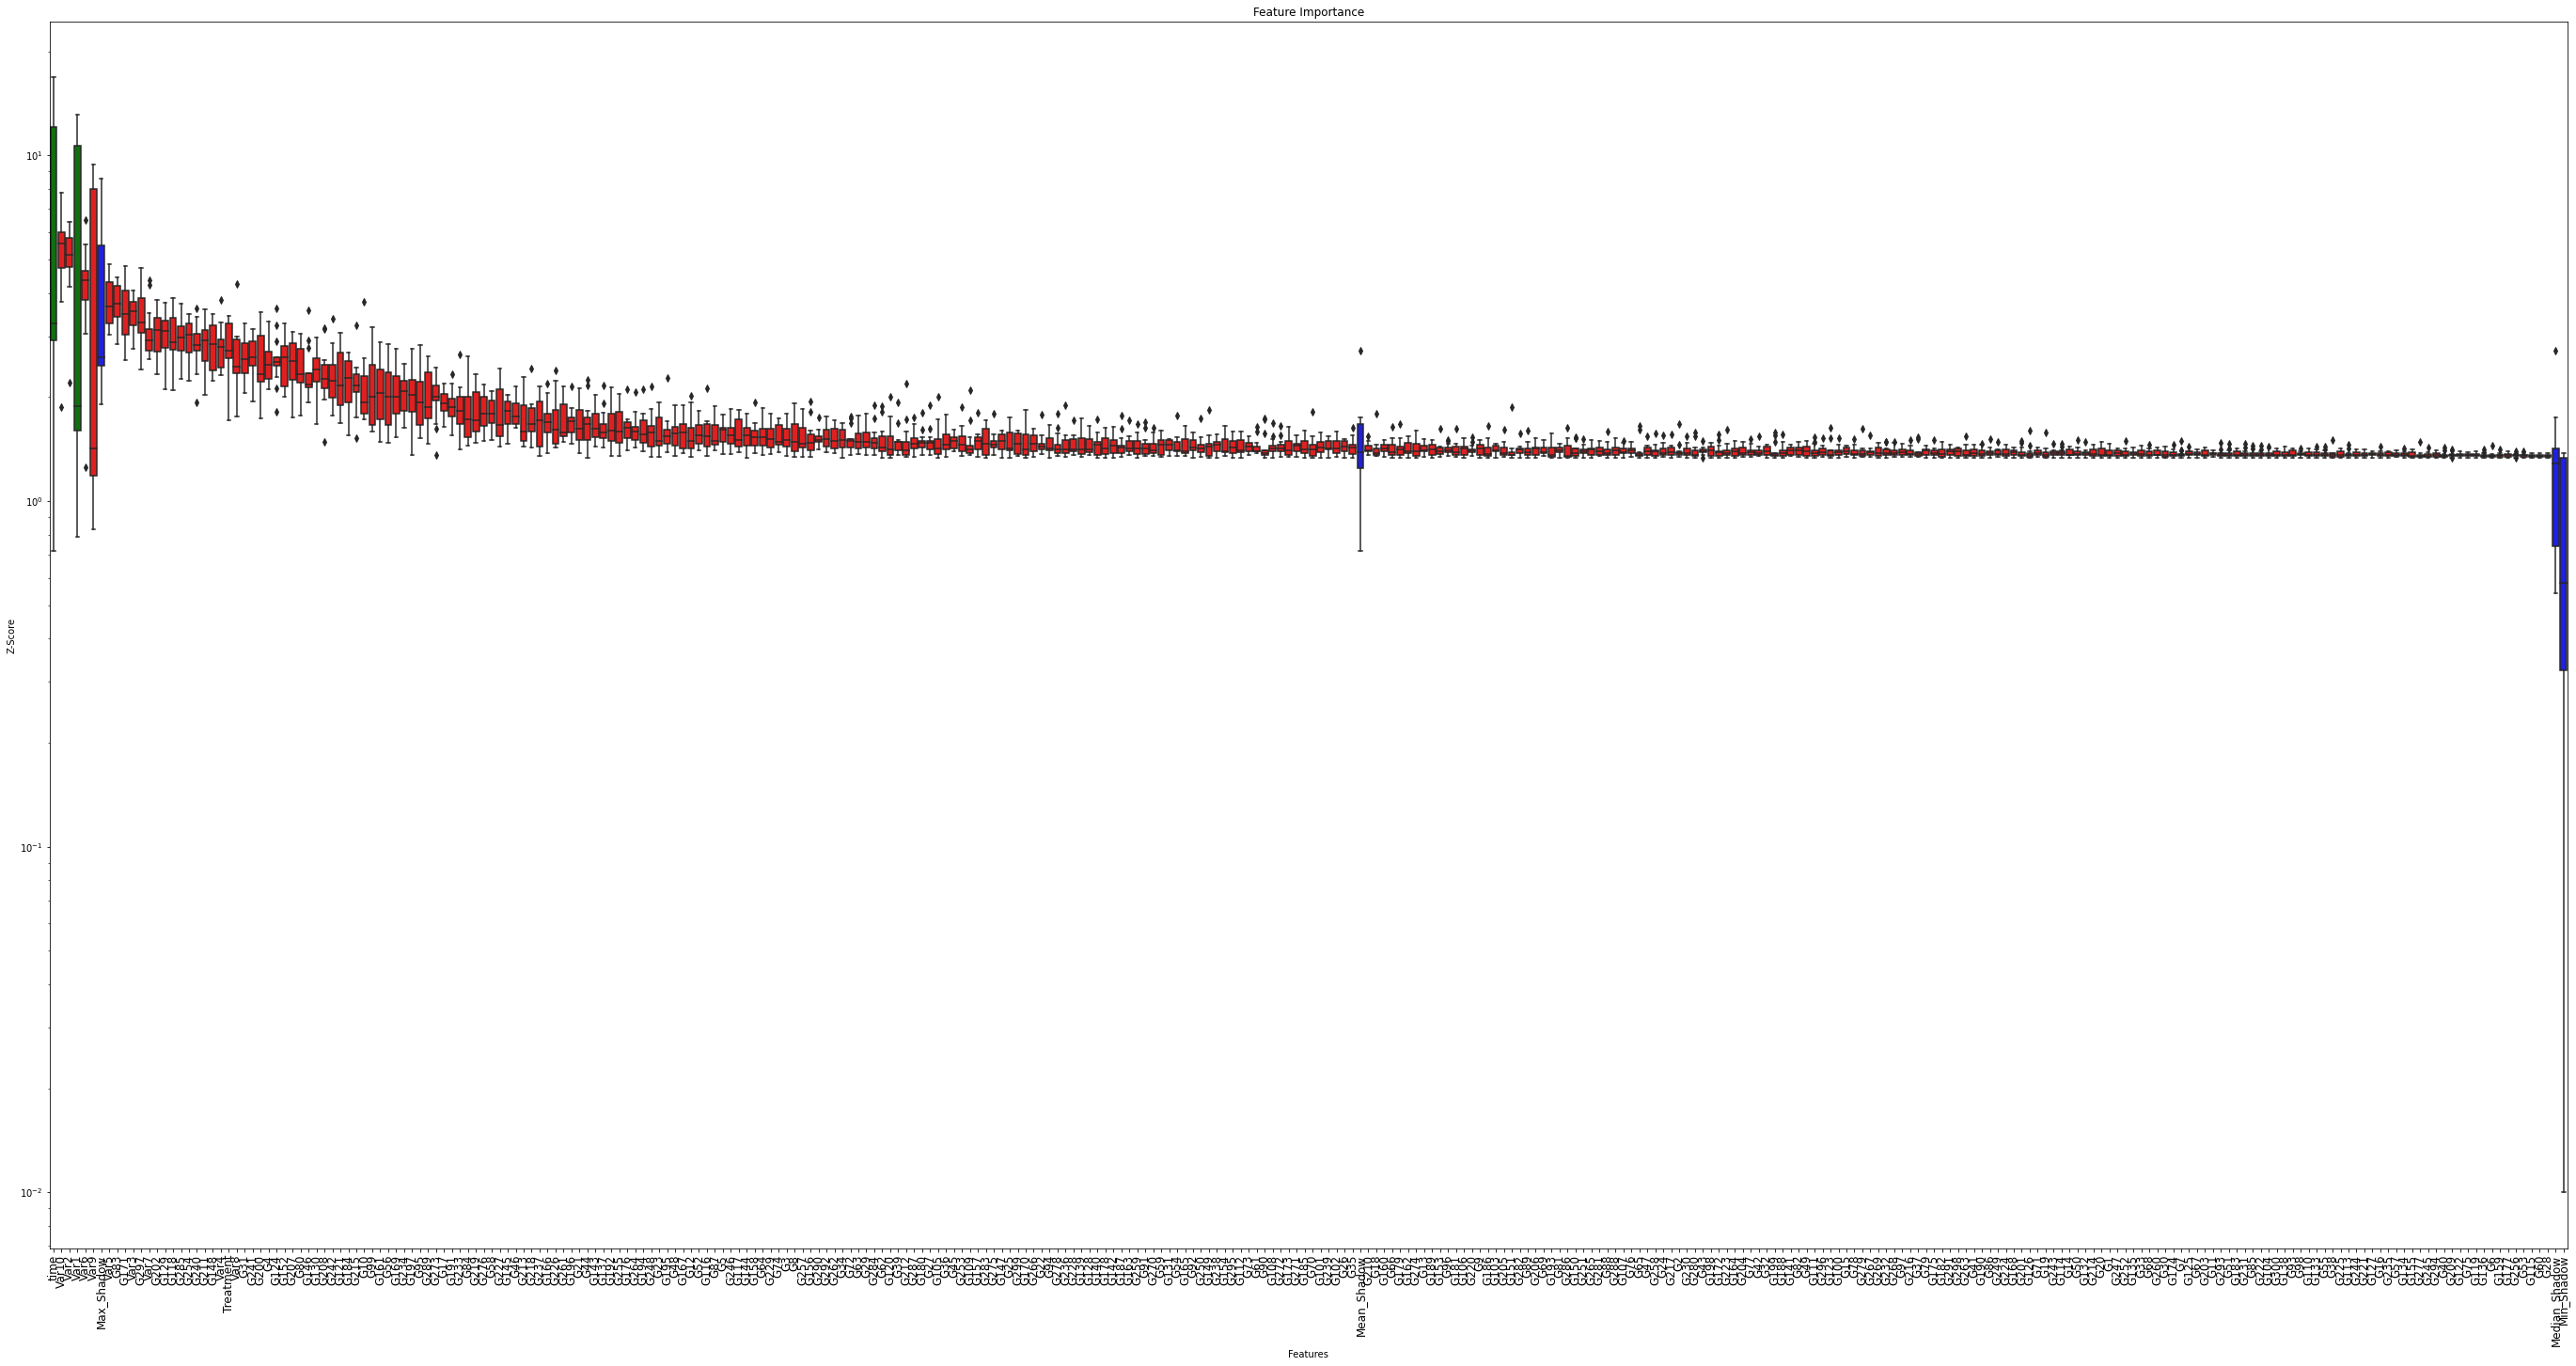

In [97]:
Feature_Selector.plot(X_size=12, which_features='all', figsize=(48,24))

In [96]:
Feature_Selector.Subset()

,Var1,time
29,1,31.305142
535,2,38.414494
695,2,62.844956
557,4,70.449651
836,3,41.040762
...,...,...
106,2,70.393075
270,0,60.247080
860,4,97.885288
435,3,38.924423


In [94]:
Feature_Selector = BorutaShap(model=lgb, importance_measure='shap', classification=True)

Feature_Selector.fit(X=X_train, y=y_train, n_trials=50, random_state=0)


2 attributes confirmed important: ['Var1', 'time']
310 attributes confirmed unimportant: ['G79', 'G260', 'G32', 'G203', 'G49', 'Var9', 'G155', 'G188', 'G64', 'G238', 'G93', 'Var10', 'G282', 'G236', 'G107', 'G48', 'G217', 'Var3', 'G111', 'G113', 'G239', 'G264', 'G130', 'G270', 'G34', 'G226', 'G83', 'G192', 'G126', 'G39', 'G8', 'G257', 'G3', 'G30', 'G143', 'G224', 'G293', 'G253', 'G56', 'G31', 'G66', 'G275', 'G241', 'G85', 'G98', 'G142', 'Var5', 'G245', 'G112', 'G54', 'G157', 'G233', 'G82', 'G135', 'G23', 'G194', 'G179', 'G201', 'G152', 'G237', 'G140', 'G243', 'G124', 'G11', 'G86', 'G169', 'G294', 'G210', 'G182', 'G146', 'G43', 'G300', 'G80', 'G35', 'G230', 'G58', 'G191', 'G108', 'G174', 'G47', 'G131', 'G144', 'G63', 'G17', 'G221', 'G105', 'G227', 'G15', 'G145', 'G2', 'G65', 'G262', 'G123', 'G249', 'G46', 'G223', 'G288', 'G193', 'G125', 'Var8', 'G248', 'G295', 'G62', 'G269', 'G219', 'G202', 'G218', 'G235', 'G252', 'G104', 'G33', 'G158', 'G296', 'G59', 'G73', 'G114', 'G55', 'G89', 'Var6'

In [139]:
# is_unbalance_=True
lgb_c = lgb.LGBMClassifier(n_estimators=1000,num_leaves=64,n_jobs=-1,
                     is_unbalance = True,boost_from_average=False)
modeling(lgb_c,X_train,X_test,y_train,y_test)

정확도 : 0.88, 정밀도 : 0.88, 재현율 : 0.99
f1-score : 0.94, auc_mac : 0.55, auc_mic : 0.55


[Text(0.5, 1.0, 'Feature Importance (gain)'),
 Text(0.5, 0, 'Feature Importance'),
 Text(0, 0.5, 'Features')]

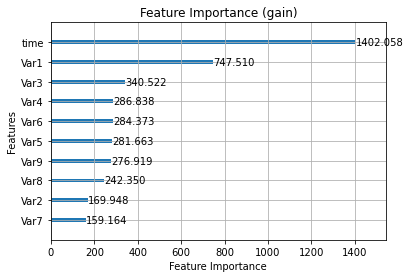

In [142]:
# GAIN
ax = lgb.plot_importance(lgb_c, max_num_features=10, importance_type='gain')
ax.set(title=f'Feature Importance (gain)',
	xlabel='Feature Importance',
	ylabel='Features')

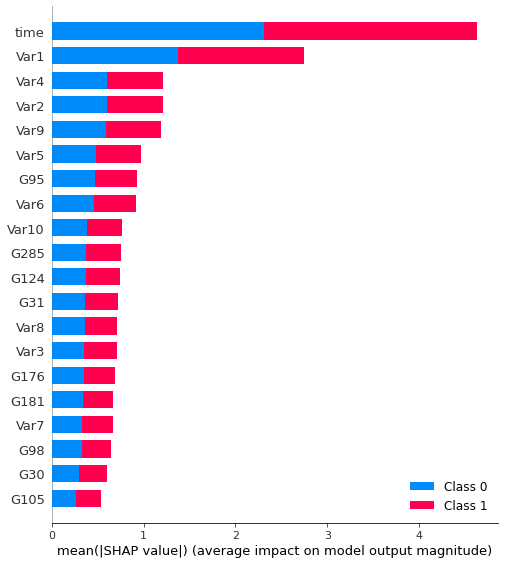

In [138]:
import shap

shap.initjs()
explainer = shap.TreeExplainer(lgb_c)
shap_values = explainer.shap_values(X_test)
fig = shap.summary_plot(shap_values, X_test)

In [150]:
from eli5.lightgbm import *
from eli5.sklearn import *
import eli5

perm = PermutationImportance(lgb_c, random_state=42).fit(X_test, y_test)
print(eli5.format_as_text(explain_weights.explain_permutation_importance(perm, feature_names = X_test.columns.values, top=40)))

explain_weights.explain_permutation_importance(perm, feature_names = X_test.columns.values, top=47)

Explained as: feature importances

Feature importances, computed as a decrease in score when feature
values are permuted (i.e. become noise). This is also known as 
permutation importance.

If feature importances are computed on the same data as used for training, 
they don't reflect importance of features for generalization. Use a held-out
dataset if you want generalization feature importances.

0.0310 ± 0.0248  time
0.0100 ± 0.0063  Var1
0.0050 ± 0.0000  G69
0.0050 ± 0.0000  G98
0.0050 ± 0.0000  Var6
0.0050 ± 0.0000  G258
0.0040 ± 0.0040  G179
0.0040 ± 0.0040  Var9
0.0030 ± 0.0049  G96
0.0030 ± 0.0049  G133
0.0030 ± 0.0049  G284
0.0020 ± 0.0049  G157
0.0020 ± 0.0049  G285
0.0020 ± 0.0049  G62
0.0020 ± 0.0049  G207
0.0010 ± 0.0040  G117
0.0010 ± 0.0040  G164
0.0010 ± 0.0040  G182
0.0010 ± 0.0040  G184
0.0010 ± 0.0040  G148
0.0010 ± 0.0040  G190
0.0010 ± 0.0040  G192
0.0010 ± 0.0040  G88
0.0010 ± 0.0040  G201
0.0010 ± 0.0040  Var8
0.0010 ± 0.0040  Var5
0.0010 ± 0.0040  G274
0.0010 ± 0.

Weight,Feature
0.0310 ± 0.0248,time
0.0100 ± 0.0063,Var1
0.0050 ± 0.0000,G258
0.0050 ± 0.0000,Var6
0.0050 ± 0.0000,G98
0.0050 ± 0.0000,G69
0.0040 ± 0.0040,Var9
0.0040 ± 0.0040,G179
0.0030 ± 0.0049,G284
0.0030 ± 0.0049,G133
